<a href="https://colab.research.google.com/github/luca-nassano/ChestXRAY/blob/master/Chexpert_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Load the libraries

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
import os
tf.random.set_seed(42)

TensorFlow 2.x selected.


# Data Loading and preprocessing

In [0]:
def record_parser(example):
    example_fmt = {
        'label': tf.io.FixedLenFeature([14], tf.float32),
        'image': tf.io.FixedLenFeature([],tf.string, default_value='')}
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_png(parsed["image"],channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, parsed['label']

def normalize_image(img,labels):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img = (img - imagenet_mean) / imagenet_std
    return img,labels

def make_dataset(filename):
  base_path = '/content/drive/My Drive/tfrecords'
  full_path = os.path.join(base_path,filename)
  dataset = tf.data.TFRecordDataset(full_path)
  parsed_dataset = dataset.map(record_parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  parsed_dataset = parsed_dataset.map(normalize_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  return parsed_dataset

batch_size = 64
#train_dataset = make_dataset('training_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
#val_dataset = make_dataset('validation_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
#train_dataset = make_dataset('training_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)
train_dataset = make_dataset('conditional_training.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)

val_dataset = make_dataset('validation_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)

test_dataset = make_dataset('test_set_cropped.tfrecords').batch(batch_size, drop_remainder=False).prefetch(1)

# Model

In [0]:
from tensorflow.keras.applications.densenet import DenseNet201,DenseNet121,DenseNet169
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, Lambda
from tensorflow.keras.models import Model

base_model = DenseNet121(include_top=False,
                             weights='imagenet',
                             input_shape=(224, 224, 3))



x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(14, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

def step_decay(epoch):
  initial_lr = 1e-4
  drop = 0.1
  return initial_lr * np.power(drop,epoch)

outputFolder = '/content/drive/My Drive/Models320/VGG19'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/model-{epoch:02d}.hdf5"

lr_scheduler = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_AUC',mode='max',patience=4)
checkpoint_cb = ModelCheckpoint(filepath,save_best_only = False,save_weights_only = False,
                               save_freq='epoch',verbose=False)


opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
callbacks = [lr_scheduler,checkpoint_cb,early_stopping]

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])

In [0]:
%%time
history = model.fit(train_dataset,
          epochs=5,
          validation_data=val_dataset,
          callbacks=callbacks,
          verbose=1,initial_epoch = 0)

# Load Models

In [0]:
from tensorflow.keras.models import load_model

base_path = '/content/drive/My Drive/Models'
def load_models(base_path):
  models = []
  for model in os.listdir(base_path):
    print('loading model: {}'.format(model))
    models.append(load_model(os.path.join(base_path,model)))
  return models

models = load_models(base_path)

# Model Predictions

In [0]:
unbatched_test = test_dataset.unbatch()
test_Y = []
for img, labels in unbatched_test:
  test_Y.append(labels.numpy())
test_Y = np.array(test_Y)

In [0]:
def make_predictions(models,test_dataset):
  predictions = []
  for model in models:
    predictions.append(model.predict(test_dataset))
  return np.mean(predictions,axis=0)

model_predictions = make_predictions(models,test_dataset)


No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


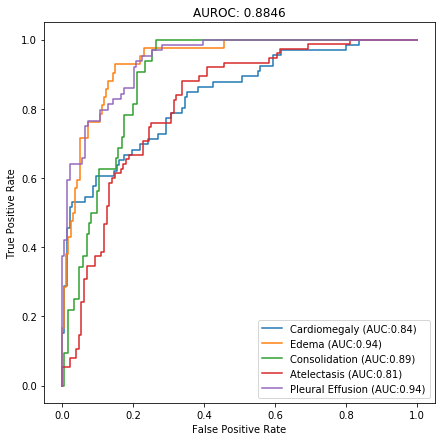

In [0]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
fig, ax = plt.subplots(1,1, figsize = (7, 7))


j = 1
aurocs = []
for (i, label) in enumerate(dummy_labels):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), model_predictions[:,i])
  if (label in target_labels):
    #ax = fig.add_subplot(2,3,j)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
    aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))


# Weighted Predictions

In [0]:
from scipy.stats import entropy

def make_weighted_predictions(models,test_dataset):
  predictions = []
  for model in models:
    predictions.append(model.predict(test_dataset))
  predictions = np.array(predictions)
  entropies = entropy([predictions,1-predictions],base = 2)
  return np.average(predictions,axis=0,weights=1-entropies)

weighted_predictions = make_weighted_predictions(models,test_dataset)


No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


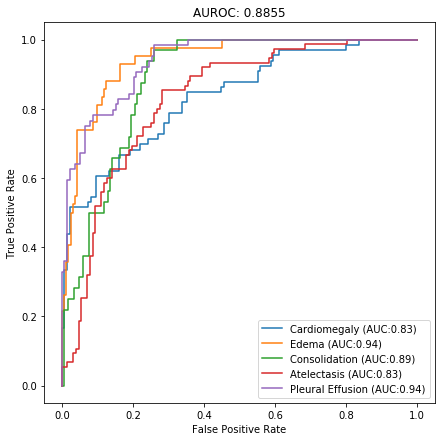

In [0]:
fig, ax = plt.subplots(1,1, figsize = (7, 7))
j = 1
aurocs = []
for (i, label) in enumerate(dummy_labels):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), weighted_predictions[:,i])
  if (label in target_labels):
    #ax = fig.add_subplot(2,3,j)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
    aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))


# Majority Voting

In [0]:
predictions = []
for model in models: 
  predictions.append(model.predict(test_dataset))
predictions = np.array(predictions)

Majority voting with threshold 0.5

In [0]:
binary_pred = predictions >= 0.5
binary_pred = binary_pred.astype(int)
votes = binary_pred.sum(axis=0)
final_pred = votes >=4
final_pred = final_pred.astype(int)

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


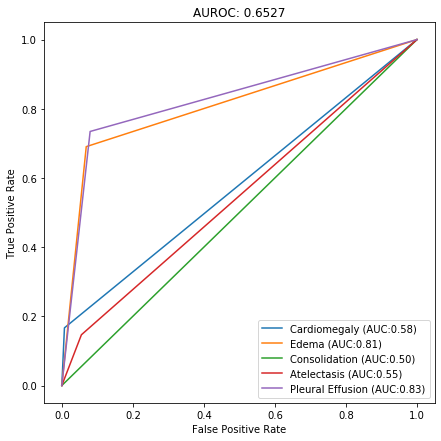

In [0]:
fig, ax = plt.subplots(1,1, figsize = (7, 7))
j = 1
aurocs = []
for (i, label) in enumerate(dummy_labels):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), final_pred[:,i])
  if (label in target_labels):
    #ax = fig.add_subplot(2,3,j)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
    aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))


Majority voting with threshold 0.2

In [0]:
binary_pred = predictions >= 0.2
binary_pred = binary_pred.astype(int)
votes = binary_pred.sum(axis=0)
final_pred = votes >=4
final_pred = final_pred.astype(int)

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


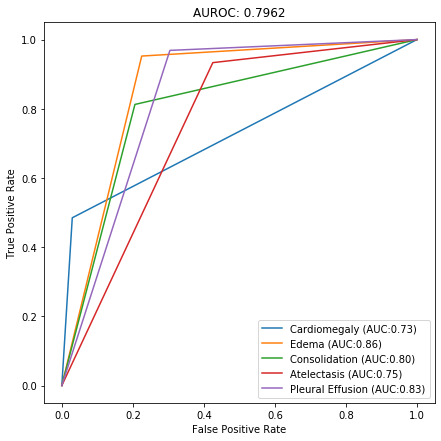

In [0]:
fig, ax = plt.subplots(1,1, figsize = (7, 7))
j = 1
aurocs = []
for (i, label) in enumerate(dummy_labels):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), final_pred[:,i])
  if (label in target_labels):
    #ax = fig.add_subplot(2,3,j)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
    aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))


# Voting

In [0]:
predictions = []
for model in models: 
  predictions.append(model.predict(test_dataset))
predictions = np.array(predictions)

In [0]:
from scipy.stats import entropy

entropies = entropy([predictions,1-predictions],base = 2)


In [0]:
binary_pred = predictions >= 0.2
binary_pred = binary_pred.astype(int)
final_pred = np.average(binary_pred,axis=0)
final_pred = final_pred.astype(float)

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


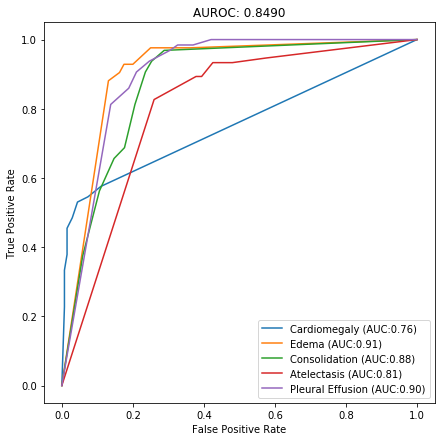

In [0]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']

fig, ax = plt.subplots(1,1, figsize = (7, 7))
j = 1
aurocs = []
for (i, label) in enumerate(dummy_labels):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), final_pred[:,i])
  if (label in target_labels):
    #ax = fig.add_subplot(2,3,j)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
    aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))


# Single model performance


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


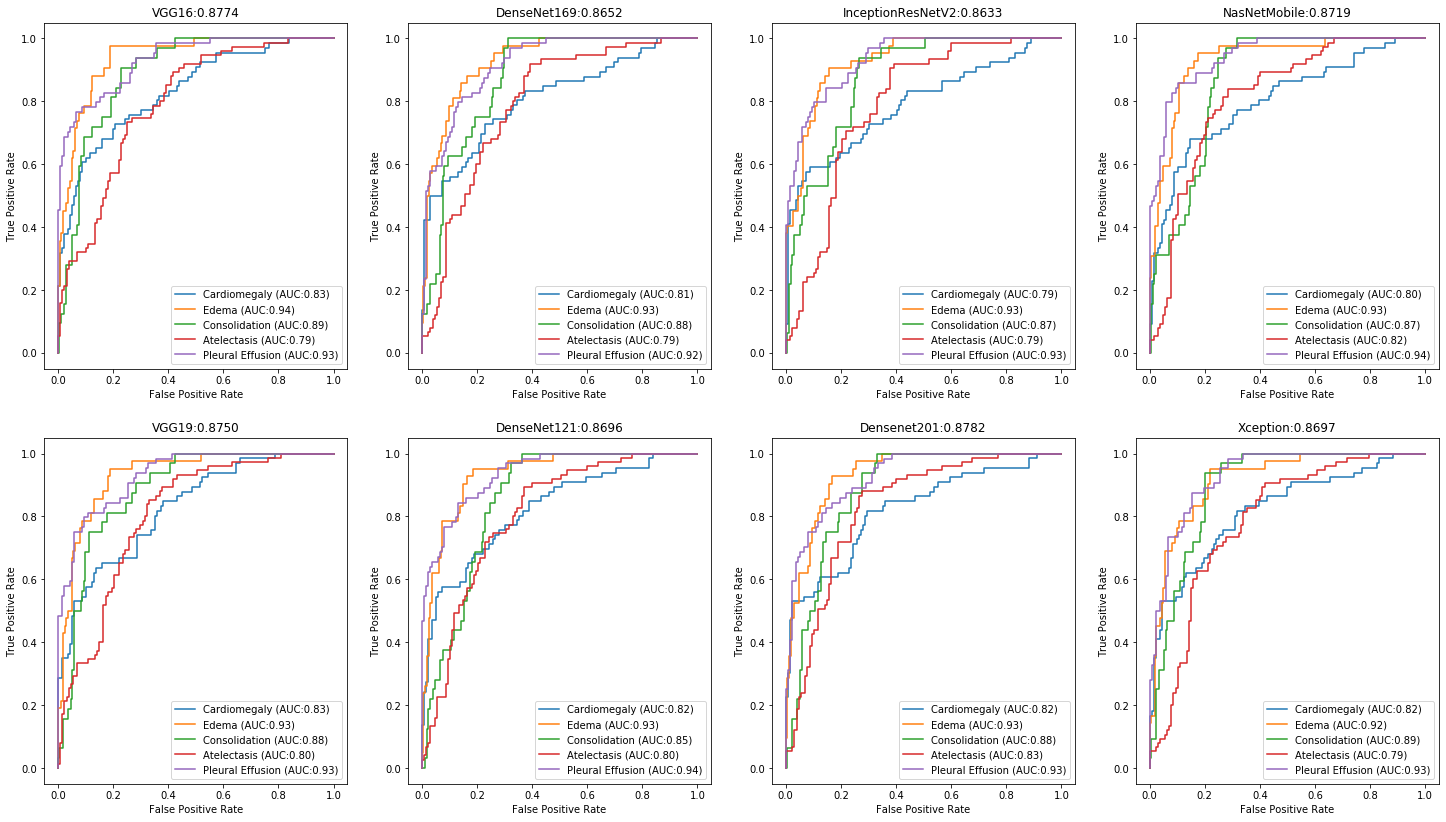

In [0]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']

titles = ['VGG16','DenseNet169','InceptionResNetV2','NasNetMobile','VGG19','DenseNet121','Densenet201','Xception']
#fig, c_ax = plt.subplots(2,3, figsize = (15, 10))
fig = plt.figure(figsize=(25,14))


j = 1
for model in models:
  pred = model.predict(test_dataset)
  aurocs= []
  ax = fig.add_subplot(2,4,j)
  for (i, label) in enumerate(dummy_labels):
      fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), pred[:,i])
      if (label in target_labels):
        #ax = fig.add_subplot(2,3,j)
        ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
        aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('{}:{:0.4f}'.format(titles[j-1],np.mean(aurocs)))
  j+=1 
    


# Stacking

In [0]:
from tensorflow.keras.models import load_model

base_path = '/content/drive/My Drive/Models'
def load_models(base_path):
  models = []
  for model in os.listdir(base_path):
    print('loading model: {}'.format(model))
    models.append(load_model(os.path.join(base_path,model)))
  return models

models = load_models(base_path)

In [0]:
def build_meta_learner_dataset(models,dataset):
  predictions = []
  for model in models: 
    predictions.append(model.predict(dataset))
  predictions = np.array(predictions)
  new_pred = []
  for i in range(predictions.shape[1]):
    new_pred.append(predictions[:,i])
  new_pred = np.array(new_pred)
  X = new_pred.reshape((new_pred.shape[0],-1))

  unbatched_dataset = dataset.unbatch()
  Y = []
  for _, labels in unbatched_dataset:
    Y.append(labels.numpy())
  Y = np.array(Y)
  return X , Y

In [0]:
train_X, train_Y= build_meta_learner_dataset(models,val_dataset)

In [0]:
rf.fit(train_X,train_Y.astype('int'))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
test_X, test_Y= build_meta_learner_dataset(models,test_dataset)

In [0]:
predictions = rf.predict_proba(test_X)

In [0]:
prob_pred = np.array(predictions)[:,:,1].T

STACKING RESULTS

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


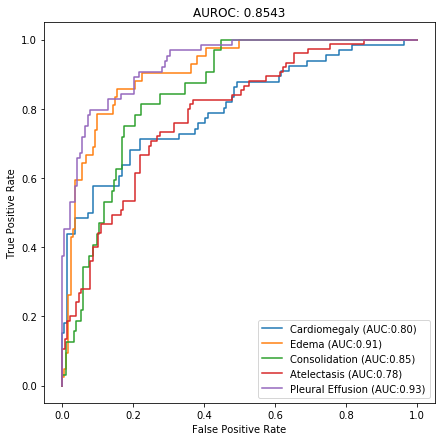

In [0]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']

fig, ax = plt.subplots(1,1, figsize = (7, 7))
j = 1
aurocs = []
for (i, label) in enumerate(dummy_labels):
  fpr, tpr, thresholds = roc_curve(test_Y[:,i].astype(int), prob_pred[:,i])
  if (label in target_labels):
    #ax = fig.add_subplot(2,3,j)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
    aurocs.append(auc(fpr, tpr))
  ax.legend()
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))


# Embedding

In [0]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/Models/densenet169_model.hdf5')

In [0]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

x = model.get_layer('global_average_pooling2d').output 
embedding_model = Model(inputs=model.input, outputs=x)

In [0]:
def build_embedding_dataset(model,dataset):
  X = model.predict(dataset)
  
  unbatched_dataset = dataset.unbatch()
  Y = []
  for _,labels in unbatched_dataset:
    Y.append(labels.numpy())
  Y = np.array(Y).astype('int')  
  
  return X,Y

In [0]:
val_X, val_Y = build_embedding_dataset(embedding_model,test_dataset)

In [0]:
import pandas as pd 
path = '/content/drive/My Drive/Embedding/DenseNet121/validation_densenet121.csv'
df = pd.read_csv(path)

In [0]:
val_X, val_Y = build_dataset(df)

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


n_estimators = [200,500,1000]
max_depth = [5, 15, 30]
min_samples_split = [2, 10, 50]
min_samples_leaf = [1, 5, 10] 
bootstrap = ['True','False']
max_features = ['sqrt','auto']


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf = RandomForestClassifier(verbose=10,random_state=42)

rf_random = RandomizedSearchCV(estimator = rf,n_iter = 100,
                               scoring='roc_auc', param_distributions= random_grid,
                               cv = 2,  n_jobs = -1,verbose=50)
rf_random.fit(val_X, val_Y.astype('int'))

In [0]:
rf_random.best_params_

{'bootstrap': 'True',
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

In [0]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1,verbose = 10 ,
                             bootstrap= True,max_depth = 30,
                             max_features= 'sqrt',
                             min_samples_leaf= 1,min_samples_split= 10,n_estimators= 200)


In [0]:
rfc.fit(train_X,train_Y.astype(int))

In [0]:
test_X, test_Y = build_embedding_dataset(embedding_model,test_dataset)

In [0]:
predictions = rfc.predict_proba(test_X)
predictions = np.array(predictions)[:,:,1].T

# Embedding Ensemble

In [0]:
def parse(x):
  return np.array(x.strip('][').split(', '),dtype=np.float32)
  
def build_dataset(df):
  df['Embedding'] = df['Embedding'].apply(lambda x: parse(x))
  values = df['Embedding'].values
  X = np.array([el for el in values])
  Y = df[df.columns[1:-1]].values
  return X, Y 

In [0]:
import os
model_name = ['DenseNet121','DenseNet169','DenseNet201',
              'VGG16','VGG19','Xception','InceptionResNetV2','NasNetMobile']
embedding_base_path = '/content/drive/My Drive/EmbeddingTrained'
model_base_path = '/content/drive/My Drive/Embedding'

In [0]:
from joblib import dump, load
import pandas as pd

predictions = []
for name in model_name:
    ##LOAD THE MODEL
    filename = 'embedding_rf_{}.joblib'.format(name.lower())
    model = load(os.path.join(embedding_base_path,filename))
    ##LOAD THE DATA
    dataset_name = 'test_{}.csv'.format(name.lower())

    dataset = pd.read_csv(os.path.join(model_base_path,name,dataset_name))
    test_X, _ = build_dataset(dataset)
    model_pred = model.predict_proba(test_X)
    model_pred = np.array(model_pred)[:,:,1].T
    predictions.append(model_pred)

final_predictions = np.array(predictions)

In [0]:
unbatched_test = test_dataset.unbatch()
test_Y = []
for img, labels in unbatched_test:
  test_Y.append(labels.numpy())
test_Y = np.array(test_Y)

**Ensemble of the 8 Random Forest**

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


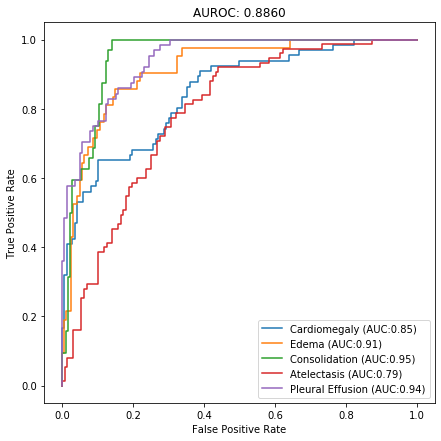

In [0]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_result(true_Y,pred_Y):
  dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                  'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

  target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']

  fig, ax = plt.subplots(1,1, figsize = (7, 7))
  j = 1
  aurocs = []
  for (i, label) in enumerate(dummy_labels):
    fpr, tpr, thresholds = roc_curve(true_Y[:,i].astype(int), pred_Y[:,i])
    if (label in target_labels):
      #ax = fig.add_subplot(2,3,j)
      ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (label, auc(fpr, tpr)))
      aurocs.append(auc(fpr, tpr))
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('AUROC: {:0.4f}'.format(np.mean(aurocs)))

plot_result(test_Y,final_predictions)

**Ensemble of the 8 Random Forest using entropy**

In [0]:
from scipy.stats import entropy 
entropies = entropy([np.array(predictions),1-np.array(predictions)],base = 2)
rf_weighted_predictions = np.average(predictions,axis=0,weights=1-entropies)


No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


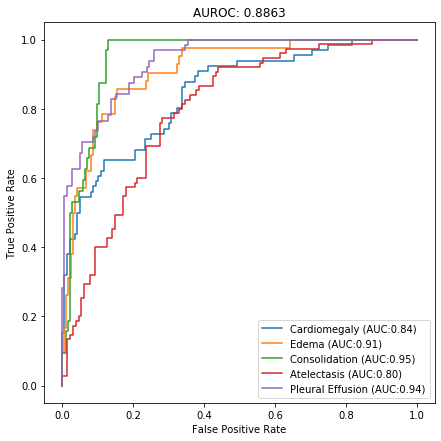

In [0]:
plot_result(test_Y,rf_weighted_predictions)

**Ensemble of Neural Network and Random Forest**

In [0]:
ensemble_predictions = np.average([rf_weighted_predictions,weighted_predictions],axis=0)

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


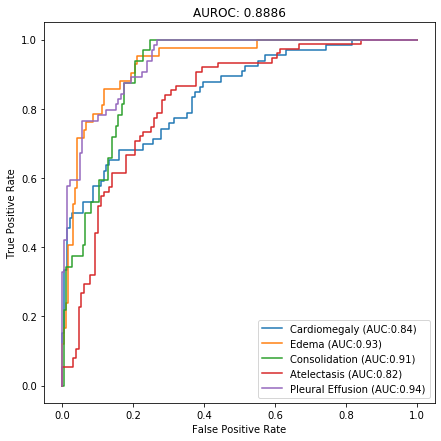

In [0]:
plot_result(test_Y,ensemble_predictions)

**Final Result**

In [0]:
final_prediction = weighted_predictions
final_prediction[:,[2,6]] = rf_weighted_predictions[:,[2,6]]

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


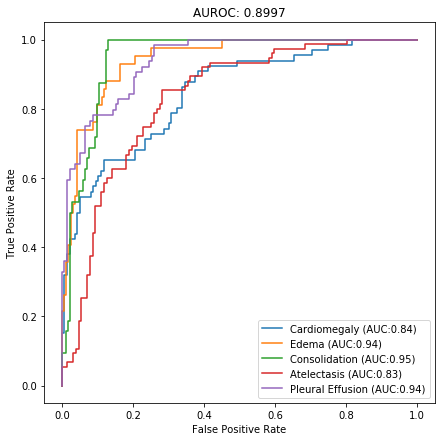

In [0]:
plot_result(test_Y, final_prediction)

# Conditional Training

In [0]:
def record_parser(example):
    example_fmt = {
        'label': tf.io.FixedLenFeature([14], tf.float32),
        'image': tf.io.FixedLenFeature([],tf.string, default_value='')}
    parsed = tf.io.parse_single_example(example, example_fmt)
    image = tf.io.decode_png(parsed["image"],channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, parsed['label']

def normalize_image(img,labels):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    img = (img - imagenet_mean) / imagenet_std
    return img,labels

def make_dataset(filename):
  base_path = '/content/drive/My Drive/tfrecords'
  full_path = os.path.join(base_path,filename)
  dataset = tf.data.TFRecordDataset(full_path)
  parsed_dataset = dataset.map(record_parser,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  parsed_dataset = parsed_dataset.map(normalize_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
  return parsed_dataset

batch_size = 64
#train_dataset = make_dataset('training_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
#val_dataset = make_dataset('validation_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)
#train_dataset = make_dataset('training_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)
train_dataset = make_dataset('training_cropped.tfrecords').shuffle(buffer_size=128).batch(batch_size, drop_remainder=True).prefetch(1)

val_dataset = make_dataset('validation_cropped.tfrecords').batch(batch_size, drop_remainder=True).prefetch(1)

test_dataset = make_dataset('test_set_cropped.tfrecords').batch(batch_size, drop_remainder=False).prefetch(1)

In [0]:
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.xception import Xception

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, Lambda
from tensorflow.keras.models import Model

base_model = NASNetMobile(include_top=False,
                             weights='imagenet',
                             input_shape=(224, 224, 3))



x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(14, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [0]:
for layer in model.layers[:-1]:
  layer.trainable = False

In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

def step_decay(epoch):
  initial_lr = 1e-4
  drop = 0.1
  return initial_lr * np.power(drop,epoch)

outputFolder = '/content/drive/My Drive/ConditionalTraining/NASNetMobile/PreTrained'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/model-{epoch:02d}.hdf5"

lr_scheduler = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_AUC',mode='max',patience=4)
checkpoint_cb = ModelCheckpoint(filepath,save_best_only = False,save_weights_only = False,
                               save_freq='epoch',verbose=False)


opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
callbacks = [lr_scheduler,checkpoint_cb]

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','AUC'])

In [0]:
%%time
history = model.fit(train_dataset,
          epochs=5,
          validation_data=val_dataset,
          callbacks=callbacks,
          verbose=1,initial_epoch = 0)

In [0]:
from tensorflow.keras.models import load_model

model_name = ['DenseNet121','DenseNet169','DenseNet201','VGG16','VGG19','Xception','InceptionResNetV2']

models = []
for el in model_name:
  mod = load_model('/content/drive/My Drive/ConditionalTraining/{}/FineTuning/model-05.hdf5'.format(el))
  models.append(mod)

In [0]:
def compute_predictions(model):
  predictions = model.predict(test_dataset)
  predictions[:,5] = predictions[:,3] * predictions[:,5]
  predictions[:,5] = predictions[:,3] * predictions[:,5]
  predictions[:,6] = predictions[:,3] * predictions[:,6]
  predictions[:,7] = predictions[:,3] * predictions[:,7]
  predictions[:,4] = predictions[:,3] * predictions[:,4]
  predictions[:,8] = predictions[:,3] * predictions[:,8]
  predictions[:,2] = predictions[:,1] * predictions[:,2]
  return predictions

In [0]:
nn_predictions = []
for model in models:
  nn_predictions.append(compute_predictions(model))
nn_predictions = np.array(nn_predictions)

In [0]:
import numpy as np
rf_predictions = np.load('/content/drive/My Drive/rf_predictions.npy')

In [0]:
from scipy.stats import entropy
rf_entropies = entropy([rf_predictions,1-rf_predictions],base = 2)
nn_entropies = entropy([nn_predictions,1-nn_predictions],base = 2)


In [0]:
rf_weighted_predictions = np.average(rf_predictions,axis=0,weights=1-rf_entropies)
nn_weighted_predictions = np.average(nn_predictions,axis=0,weights=1-nn_entropies)

In [0]:
final_predictions = np.average([rf_weighted_predictions,nn_weighted_predictions],axis=0)

No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


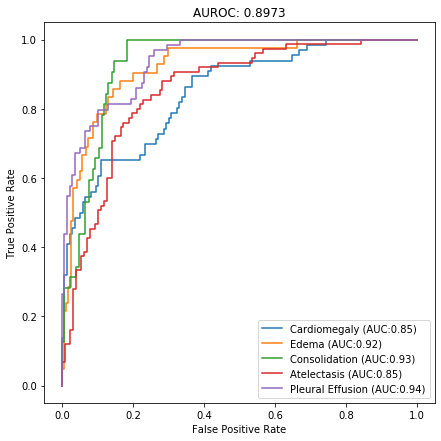

In [0]:
plot_result(test_Y,final_predictions)